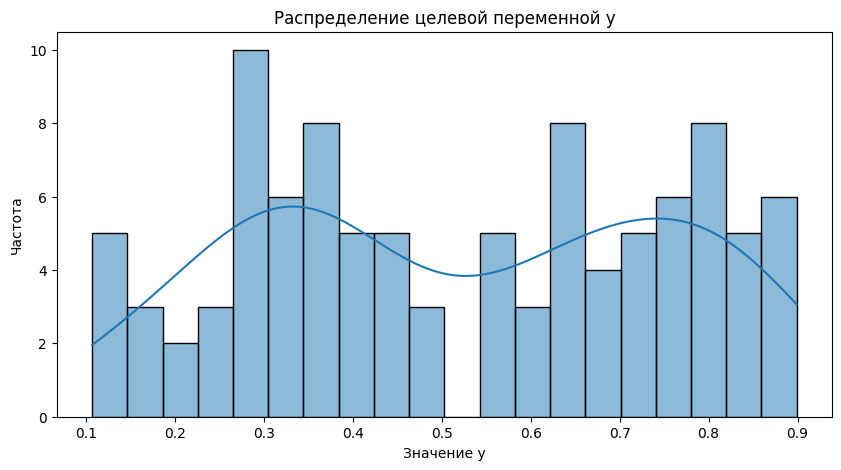

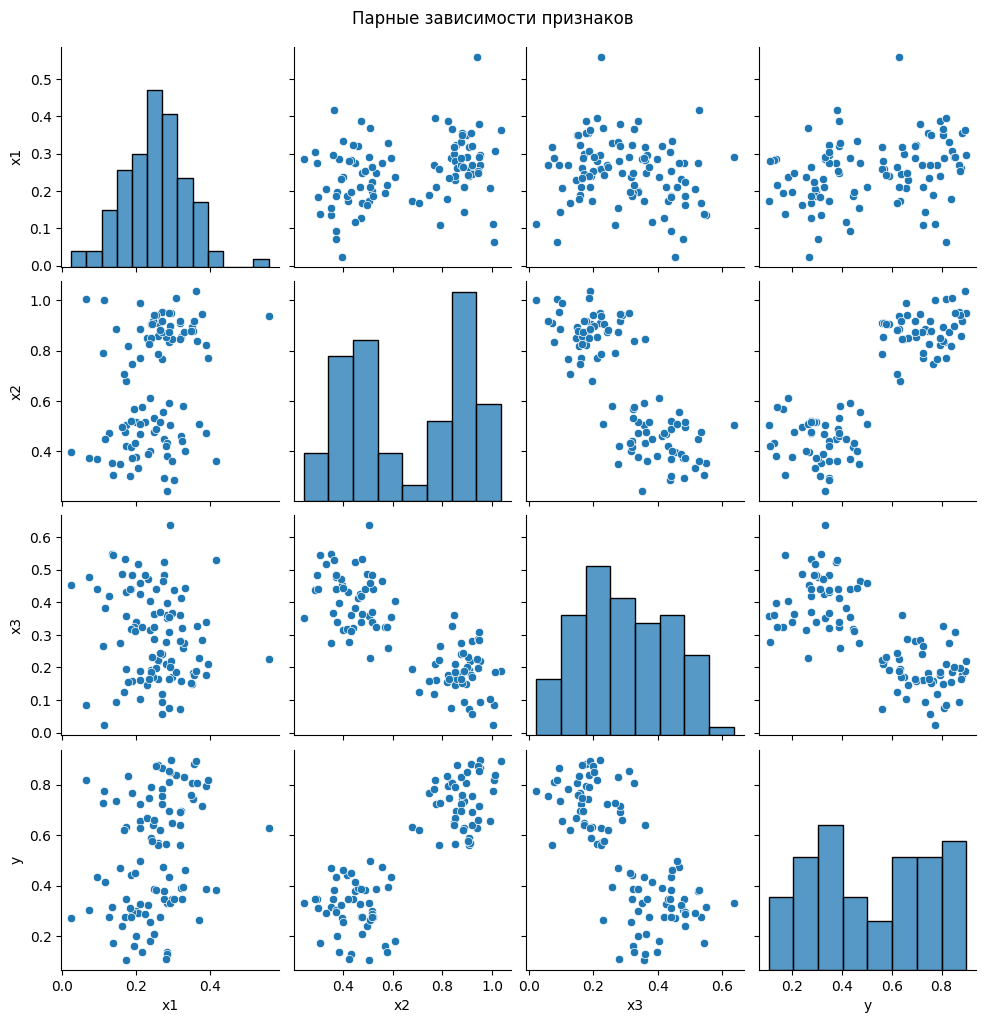

Начало поиска лучших параметров...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Поиск завершен!

Лучшие параметры модели: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 0.1}
Усредненная максимальная ошибка: 0.208501
Лучший показатель на кросс-валидации: 0.208501


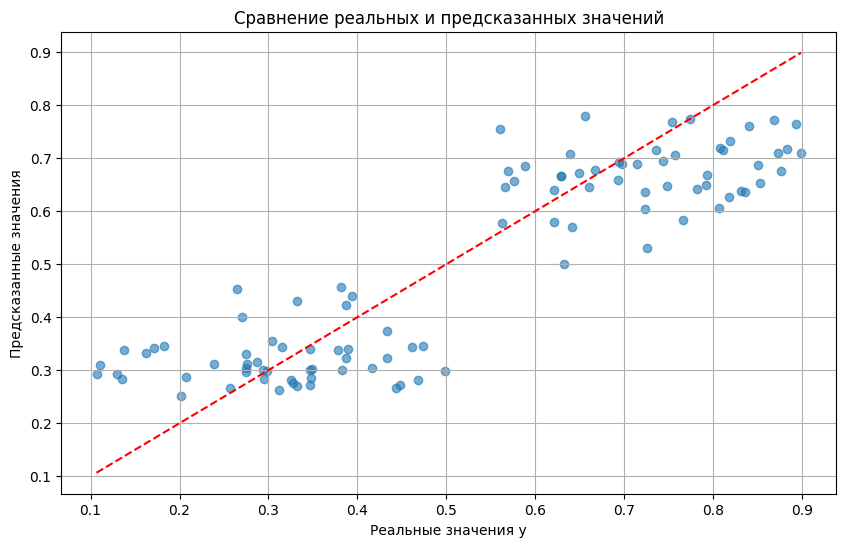

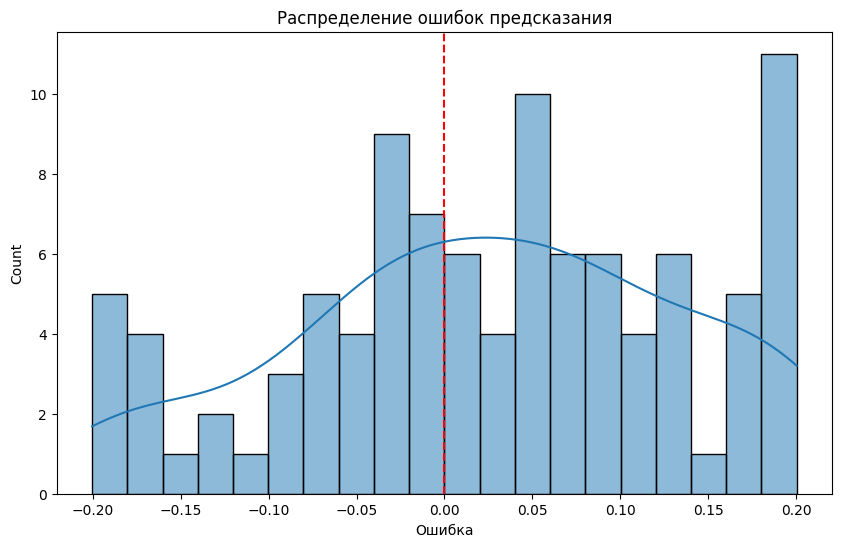


РЕЗУЛЬТАТ: Модель удовлетворяет условию задачи!
Максимальная ошибка не превышает 0.22


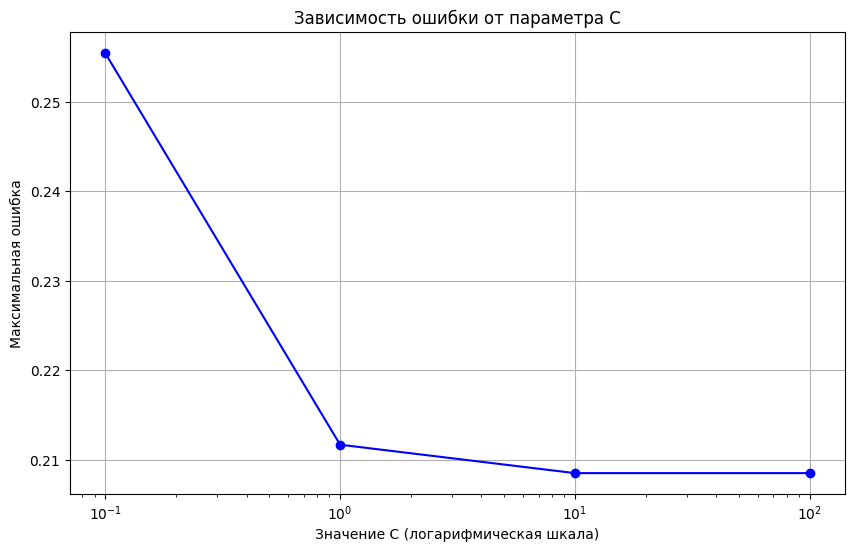

In [3]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных из CSV-файла
# Разделитель - точка с запятой, первая строка содержит заголовки
data = pd.read_csv('dataset_01.csv', sep=';')

# Выделение признаков (x1, x2, x3) и целевой переменной (y)
X = data[['x1', 'x2', 'x3']]  # Независимые переменные
y = data['y']  # Целевая переменная для регрессии

# Визуализация 1: Распределение целевой переменной
plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True, bins=20)
plt.title('Распределение целевой переменной y')
plt.xlabel('Значение y')
plt.ylabel('Частота')
plt.show()

# Визуализация 2: Парные зависимости между признаками
sns.pairplot(data[['x1', 'x2', 'x3', 'y']])
plt.suptitle('Парные зависимости признаков', y=1.02)
plt.show()

# Создание конвейера обработки данных:
# 1. StandardScaler - стандартизация данных (среднее=0, std=1)
# 2. SVR - метод опорных векторов для регрессии с RBF-ядром
model = make_pipeline(
    StandardScaler(),  # Нормализуем данные для устойчивости SVR
    SVR(kernel='rbf')  # Используем радиальное базисное ядро для учета нелинейностей
)

# Параметры для оптимизации методом сеточного поиска
param_grid = {
    'svr__C': [0.1, 1, 10, 100],  # Параметр регуляризации (штраф за ошибки)
    'svr__gamma': [0.01, 0.1, 1, 10],  # Влияние отдельных точек (радиус действия)
    'svr__epsilon': [0.01, 0.05, 0.1, 0.2]  # Допустимая погрешность в трубах
}

# Инициализация поиска по сетке параметров:
# - cv=5: 5-кратная кросс-валидация
# - scoring='neg_max_error': используем максимальную ошибку как метрику
# - n_jobs=-1: используем все доступные ядра процессора
grid = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='neg_max_error', 
    n_jobs=-1,
    verbose=1  # Выводим прогресс
)

print("Начало поиска лучших параметров...")
grid.fit(X, y)  # Запуск поиска по сетке параметров
print("Поиск завершен!")

# Лучшая модель после оптимизации параметров
best_model = grid.best_estimator_

# Проверка качества лучшей модели с помощью кросс-валидации
# Используем те же 5 фолдов для согласованности результатов
scores = cross_val_score(
    best_model, 
    X, 
    y, 
    cv=5, 
    scoring='neg_max_error'
)

# Преобразование результатов (метрика возвращает отрицательные значения)
# Берем абсолютное значение и усредняем
mean_max_error = np.mean(np.abs(scores))

# Вывод результатов
print(f"\nЛучшие параметры модели: {grid.best_params_}")
print(f"Усредненная максимальная ошибка: {mean_max_error:.6f}")
print(f"Лучший показатель на кросс-валидации: {-grid.best_score_:.6f}")

# Визуализация 3: Сравнение реальных и предсказанных значений
best_model.fit(X, y)  # Обучаем модель на всех данных
y_pred = best_model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Линия идеальных предсказаний
plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Реальные значения y')
plt.ylabel('Предсказанные значения')
plt.grid(True)
plt.show()

# Визуализация 4: Ошибки предсказаний
errors = y - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=20)
plt.title('Распределение ошибок предсказания')
plt.xlabel('Ошибка')
plt.axvline(x=0, color='r', linestyle='--')  # Вертикальная линия на нуле
plt.show()

# Проверка выполнения условия задачи
if mean_max_error <= 0.22:
    print("\nРЕЗУЛЬТАТ: Модель удовлетворяет условию задачи!")
    print("Максимальная ошибка не превышает 0.22")
    
    # Дополнительная визуализация для лучших параметров
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid.cv_results_)
    
    # Сравнение разных значений C при лучших gamma и epsilon
    best_gamma = grid.best_params_['svr__gamma']
    best_epsilon = grid.best_params_['svr__epsilon']
    subset = results[
        (results['param_svr__gamma'] == best_gamma) &
        (results['param_svr__epsilon'] == best_epsilon)
    ]
    
    plt.plot(subset['param_svr__C'], -subset['mean_test_score'], 'bo-')
    plt.xscale('log')
    plt.title('Зависимость ошибки от параметра C')
    plt.xlabel('Значение C (логарифмическая шкала)')
    plt.ylabel('Максимальная ошибка')
    plt.grid(True)
    plt.show()
    
else:
    print("\nРЕЗУЛЬТАТ: Требуется дополнительная оптимизация")
    print("Максимальная ошибка превышает допустимый порог 0.22")